Example Notebook
============

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
from IPython.display import display
from lda_for_fragments import Ms2Lda

<h2>1. Feature Extraction</h2>

There are two ways to generate the input matrices, described below in option (a) and (b).

<h3>a. Loading Existing Input Matrices</h3>

You can run the R feature extraction pipeline separately to produce the necessary input matrices for MS2LDA. All the R scripts necessary to perform feature extraction can be found in the "R" folder (one level above from the current "notebooks" folder you're in now). 

The entry point to the pipeline is **R/MS1MS2_MatrixGeneration.R**, so load that file in your favourite R development environment (e.g. RStudio), set the working directory to the "R" folder. Next, you'd need to configure all the parameters of the pipeline. This can be found in **config.yml** file. The default parameters provided there were were for our data generated on pHILIC-MS and HILIC-MS runs in positive ionisation mode. You can try with these values first and modify them as necessary if you aren't getting sensible results in the count matrices that can be used by LDA.

Note: RMassBank is one of the dependencies of the pipeline. RMassBank relies on rJava. The following is a common problem that you might encounter when configuring rJava : http://stackoverflow.com/questions/12872699/error-unable-to-load-installed-packages-just-now. 

In the cell below, we load some CSV files produced after running the feature extraction pipeline in R.

In [ ]:
fragment_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_fragments.csv'
neutral_loss_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_losses.csv'
mzdiff_filename = None
ms1_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms1.csv'
ms2_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

<h3>b. Running the Feature Extraction Pipeline</h3>

For convenience, we've also provided a wrapper method (shown below) in MS2-LDA to call the the feature extraction pipeline. This takes as input the full scan and fragmentation files (defined in config_filename) and produces the various count matrices used as input to LDA.

Note: Since we're calling R codes from Python, this depends on http://rpy.sourceforge.net/, which doesn't seem to be well-supported in Windows.

In [ ]:
# path to the folder containing the R scripts used for feature extraction 
script_folder = '/home/joewandy/git/metabolomics_tools/justin/R'

# path to the configuration file for feature extraction
config_filename = os.path.join(script_folder, 'config.yml')

# too many warning messages printed from R
import warnings
warnings.filterwarnings("ignore")

# run the feature extraction pipeline, this will run for a long time!!
ms2lda = Ms2Lda.run_feature_extraction(script_folder, config_filename)

<hr/>

<h2>2. Analysis</h2>

<h3>a. Run LDA</h3>

Once the data has been loaded by performing either step 1(a) or 1(b), we're now ready to run LDA analysis.

In [ ]:
### all the parameters you need to specify to run LDA ###

n_topics = 300 # 300 - 400 topics from cross-validation
n_samples = 1000 # 100 is probably okay for testing. For manuscript, use > 500-1000.
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in. Ignored if n_burn = 0
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

<h3>b. (Optional) In-silico Annotation using SIRIUS</h3>

For the purpose of visualisation in step 3(c), we can annotate the MS1 and MS2 peaks using [SIRIUS](http://bio.informatik.uni-jena.de/software/sirius/), an in-silico fragmentation tool written in Java. At the moment, each parent MS1 peak and its associated MS2 spectra are run through SIRIUS separately. Isotopic information, which can be used to improve annotation, is not used yet.

If you run this annotation step before saving the project in step (c) below, the annotation information will be saved into the ms1 and ms2 peak info too.

In [ ]:
# sirius_platform specifies the profile used by SIRIUS
# ppm_max is the mass tolerance used by SIRIUS when assigning elemental formulae
# mode is either 'pos' or 'neg'
# max_ms1 excludes any MS1 with m/z > 400 from annotation since it takes too long to process
ms2lda.annotate_with_sirius(sirius_platform='orbitrap', ppm_max=5, mode='pos', max_ms1=400)

In [ ]:
display(ms2lda.ms1)

In [ ]:
display(ms2lda.ms2)

<h3>c. (Optional) In-silico Annotation using EF Assigner</h3>

If you have not installed SIRIUS, we have also provided a simple in-silico annotation method (EF Assigner) written completely in Python. The method works by combinatorially enumerating all candidate formulae that can be produced by the precursor mass, applying the 7 golden rules to reduce the candidate set and returning the formula closest in mass to the observed precursor mass as the 'top hit'. This method does not assign formulae to the losses, only the fragments.

Similar to the SIRIUS annotation above, we can call EF Assigner as shown in the cell below. This will take a while as EF Assigner performs annotations on the MS1 peaklist first, followed by on the MS2 peaklist.

In [ ]:
ms2lda.annotate_with_ef_assigner(mode='pos', ppm_max=5, max_ms1=400)

In [ ]:
display(ms2lda.ms1)

In [ ]:
display(ms2lda.ms2)

<h3>d. (Optional) Saving Project</h3>

Save the whole project so we don't have to re-run everything the next time ..

In [ ]:
# leave the message parameter out if nothing to say
ms2lda.save_project('results/beer3pos.project', message="Beer3Pos analysis for the manuscript with SIRIUS EF Annotation")

<hr/>

<h2>3. Results</h2>

<h3>a. Resuming Project (Optional)</h3>

If you saved the project in step (2c), you can resume from here the next time you load this notebook ..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import pylab as plt
from IPython.display import display
from lda_for_fragments import Ms2Lda

In [2]:
ms2lda = Ms2Lda.resume_from('results/beer3pos.project')

Project loaded from results/beer3pos.project time taken = 21.4475231171
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Fri Oct 16 02:56:11 2015
 - message = Beer3Pos analysis for the manuscript with SIRIUS EF Annotation


In [ ]:
display(ms2lda.ms1)

In [ ]:
display(ms2lda.ms2)

<h3>b. Thresholding</h3>

For the purpose of visualisation only, we threshold the document-topic and topic-word distributions produced by LDA, so we can say which topics are used in which documents, and which words 'belongs' to a topic. This needs to be done before step (b) and (c) below.

In [3]:
# Thresholding the doc_topic and topic_word matrices
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

From this point onwards, we will refer to an LDA topic as **Mass2Motif** when interpreting the results.

<h3>c. Print Results</h3>

Print which fragment/loss features occur with probability above the thresholds defined above in each Mass2Motif.

In [ ]:
ms2lda.print_motif_features()

We can also save the output to CSV files

In [ ]:
ms2lda.write_results('beer3pos_csv_out')

<h3>d. Cosine Clustering (optional)</h3>

We plot the cosine clustering of the parent ions to investigate the agreement/difference between clusters vs motifs. 

In [4]:
# method is either 'hierarchical' or 'greedy'
peak_names, clustering = ms2lda.run_cosine_clustering(method='greedy')

In [5]:
print "Found {} clusters".format(np.max(clustering))
print plt

Found 309 clusters
<module 'pylab' from '/home/joewandy/anaconda/lib/python2.7/site-packages/pylab.pyc'>


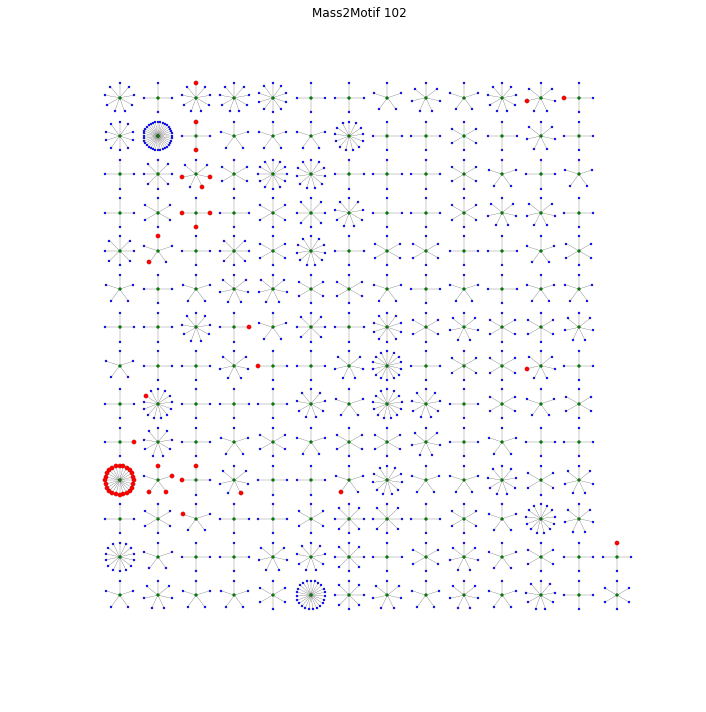

In [40]:
fig = ms2lda.plot_cosine_clustering(102, clustering, peak_names)

<h3>e. Visualisation</h3>

A visualisation module is provided to explore the results. This can be run in either interactively in the browser or non-interactively by plotting all results in this notebook (which can be a lot of plots!)

<h4>Set Visualisation Parameters</h4>

In [ ]:
# If True, an interactive visualisation is shown in a separate tab. 
# You need to interrupt the kernel to stop it once you're done with it (from the menu above, Kernel > Interrupt).
interactive=True

In [ ]:
# Used for graph visualisation in the interactive mode only. 
# Specifies the 'special' nodes to be coloured differently.
special_nodes = [
    # you can colour the MS1 peak in the graph
    # 'doc_peakid', where peakid is the peak ID of the MS1 peak    
    ('doc_21758', 'gold'),
    # you can also colour the Mass2Motif in the graph
    ('motif_0', '#ff1493')
]

# If nothing ..
# special_nodes = None

In [ ]:
# read the annotation assigned to each Mass2Motif from a CSV file
# this could also be stored in e.g. a database
import csv
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    print str(key) + '\t' + val
    motif_annotation[key] = val

# here we set all the motifs having annotations as special nodes too
motif_colour = '#CC0000'
to_add_list = ['motif_' + str(x) for x in motif_annotation.keys()]
for item in to_add_list:
    special_nodes.append((item, motif_colour))

# If nothing ..
# motif_annotation = None

<h4>Run Visualisation</h4>

In [ ]:
ms2lda.plot_lda_fragments(interactive=interactive, to_highlight=special_nodes, additional_info=motif_annotation)